In [1]:
# link to the reference :https://debuggercafe.com/custom-object-detection-using-pytorch-faster-rcnn/?fbclid=IwAR16wkrFVwUvYcEHN9XCFI8KXOaJiNzyzNDh-DYAfFwXyh2Jxm0mRxKwqm4
# please upload the dataset folder in Collab Notebooks folder  in Google Drive
# change the runtime of collab to GPU

In [2]:
# mount google drive

from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
####### model.py #########
import torchvision
 
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
 
def create_model(num_classes):
    
    # load Faster RCNN pre-trained model
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    
    # get the number of input features 
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # define a new head for the detector with required number of classes
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes) 
 
    return model


In [4]:
###### config.py ########
import torch
 
BATCH_SIZE = 5 # increase / decrease according to GPU memeory
RESIZE_TO = 416 # resize the image for training and transforms
NUM_EPOCHS = 10 # number of epochs to train for
 
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
 
# training images and XML files directory
TRAIN_DIR = '/content/gdrive/MyDrive/Colab Notebooks/ACID.v1-acid01.voc/train'

# validation images and XML files directory
VALID_DIR = '/content/gdrive/MyDrive/Colab Notebooks/ACID.v1-acid01.voc/valid'
 
# classes: 0 index is reserved for background
classes = CLASSES = [
    'background', 'excavator', 'dump_truck', 'concrete_mixer_truck'
]
NUM_CLASSES = 4
 
# whether to visualize images after crearing the data loaders
VISUALIZE_TRANSFORMED_IMAGES = False
 
# location to save model and plots
OUT_DIR = '/content/gdrive/MyDrive/Colab Notebooks/output_rcnn'
SAVE_PLOTS_EPOCH = 2 # save loss plots after these many epochs
SAVE_MODEL_EPOCH = 2 # save model after these many epochs

In [5]:
!pip install albumentations==1.0.3

In [6]:
###### utils.py #######
import albumentations as A
import cv2
import numpy as np
 
from albumentations.pytorch import ToTensorV2
# from config import DEVICE, CLASSES as classes
 
# this class keeps track of the training and validation loss values...
# ... and helps to get the average for each epoch as well
class Averager:
    def __init__(self):
        self.current_total = 0.0
        self.iterations = 0.0
        
    def send(self, value):
        self.current_total += value
        self.iterations += 1
    
    @property
    def value(self):
        if self.iterations == 0:
            return 0
        else:
            return 1.0 * self.current_total / self.iterations
    
    def reset(self):
        self.current_total = 0.0
        self.iterations = 0.0
 
def collate_fn(batch):
    """
    To handle the data loading as different images may have different number 
    of objects and to handle varying size tensors as well.
    """
    return tuple(zip(*batch))
 
# define the training tranforms
def get_train_transform():
    return A.Compose([
        # A.Flip(0.5),
        # A.RandomRotate90(0.5),
        # A.MotionBlur(p=0.2),
        # A.MedianBlur(blur_limit=3, p=0.1),
        ToTensorV2(p=1.0),
    ])

  # bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels'])
# define the validation transforms
def get_valid_transform():
    return A.Compose([
        ToTensorV2(p=1.0),
    ])
 
 
def show_tranformed_image(train_loader):
    """
    This function shows the transformed images from the `train_loader`.
    Helps to check whether the tranformed images along with the corresponding
    labels are correct or not.
    Only runs if `VISUALIZE_TRANSFORMED_IMAGES = True` in config.py.
    """
    if len(train_loader) > 0:
        for i in range(1):
            images, targets = next(iter(train_loader))
            images = list(image.to(DEVICE) for image in images)
            targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]
            boxes = targets[i]['boxes'].cpu().numpy().astype(np.int32)
            sample = images[i].permute(1, 2, 0).cpu().numpy()
            for box in boxes:
                cv2.rectangle(sample,
                            (box[0], box[1]),
                            (box[2], box[3]),
                            (0, 0, 255), 2)
            cv2.imshow('Transformed image', sample)
            cv2.waitKey(0)
            cv2.destroyAllWindows()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Number of training samples: 500
Number of validation samples: 500

Number of training images: 500


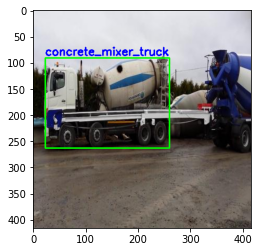

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


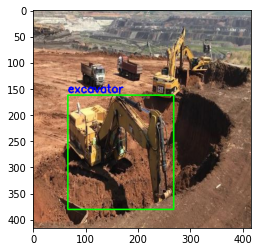

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


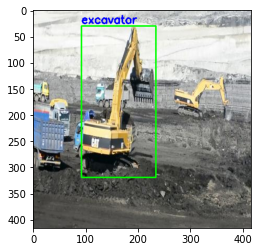

In [7]:
####### datasets.py #######
%matplotlib inline
import matplotlib.pyplot as plt
import torch
import cv2
import numpy as np
import os
import glob as glob
from google.colab.patches import cv2_imshow
 
from xml.etree import ElementTree as et
# from config import CLASSES, RESIZE_TO, TRAIN_DIR, VALID_DIR, BATCH_SIZE
from torch.utils.data import Dataset, DataLoader
# from utils import collate_fn, get_train_transform, get_valid_transform
 
# the dataset class
class AcidDataset(Dataset):
    def __init__(self, dir_path, width, height, classes, transforms=None):
        self.transforms = transforms
        self.dir_path = dir_path
        self.height = height
        self.width = width
        self.classes = classes
        
        # get all the image paths in sorted order
        self.image_paths = glob.glob(f"{self.dir_path}/*.jpg")
        #self.all_images = [image_path.split('/')[-1] for image_path in self.image_paths] # "/" for linux
        self.all_images = [image_path.split('\\')[-1] for image_path in self.image_paths] # '\\' for windows
        self.all_images = sorted(self.all_images)
        # test smaller size
        self.all_images = self.all_images[0:500] 
 
    def __getitem__(self, idx):
        # capture the image name and the full image path
        image_name = self.all_images[idx]
        image_path = os.path.join(self.dir_path, image_name)
 
        # read the image
        image = cv2.imread(image_path)
        # convert BGR to RGB color format
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image_resized = cv2.resize(image, (self.width, self.height))
        image_resized /= 255.0
        
        # capture the corresponding XML file for getting the annotations
        annot_filename = image_name[:-4] + '.xml'
        annot_file_path = os.path.join(self.dir_path, annot_filename)
        
        boxes = []
        labels = []
        tree = et.parse(annot_file_path)
        root = tree.getroot()
        
        # get the height and width of the image
        image_width = image.shape[1]
        image_height = image.shape[0]
        
        # box coordinates for xml files are extracted and corrected for image size given
        for member in root.findall('object'):
            # map the current object name to `classes` list to get...
            # ... the label index and append to `labels` list
            labels.append(self.classes.index(member.find('name').text))
            
            # xmin = left corner x-coordinates
            xmin = int(member.find('bndbox').find('xmin').text)
            # xmax = right corner x-coordinates
            xmax = int(member.find('bndbox').find('xmax').text)
            # ymin = left corner y-coordinates
            ymin = int(member.find('bndbox').find('ymin').text)
            # ymax = right corner y-coordinates
            ymax = int(member.find('bndbox').find('ymax').text)
            
            # resize the bounding boxes according to the...
            # ... desired `width`, `height`
            # xmin_final = (xmin/image_width)*self.width
            # xmax_final = (xmax/image_width)*self.width
            # ymin_final = (ymin/image_height)*self.height
            # yamx_final = (ymax/image_height)*self.height

            xmin_final = xmin
            xmax_final = xmax
            ymin_final = ymin
            yamx_final = ymax
            
            boxes.append([xmin_final, ymin_final, xmax_final, yamx_final])
        
        # bounding box to tensor
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # area of the bounding boxes
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # no crowd instances
        iscrowd = torch.zeros((boxes.shape[0],), dtype=torch.int64)
        # labels to tensor
        labels = torch.as_tensor(labels, dtype=torch.int64)
 
        # prepare the final `target` dictionary
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["area"] = area
        target["iscrowd"] = iscrowd
        image_id = torch.tensor([idx])
        target["image_id"] = image_id
 
        # apply the image transforms
        if self.transforms:
            sample = self.transforms(image = image_resized,
                                     bboxes = target['boxes'],
                                     labels = labels)
            image_resized = sample['image']
            target['boxes'] = torch.Tensor(sample['bboxes'])
            
        return image_resized, target
 
    def __len__(self):
        return len(self.all_images)
 
# prepare the final datasets and data loaders
train_dataset = AcidDataset(TRAIN_DIR, RESIZE_TO, RESIZE_TO, CLASSES, get_train_transform())
valid_dataset = AcidDataset(VALID_DIR, RESIZE_TO, RESIZE_TO, CLASSES, get_valid_transform())
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0,
    collate_fn=collate_fn
)
valid_loader = DataLoader(
    valid_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,
    collate_fn=collate_fn
)
print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of validation samples: {len(valid_dataset)}\n")
 
# execute datasets.py using Python command from Terminal...
# ... to visualize sample images
# USAGE: python datasets.py
if __name__ == '__main__':
    # sanity check of the Dataset pipeline with sample visualization
    dataset = AcidDataset(
        TRAIN_DIR, RESIZE_TO, RESIZE_TO, CLASSES
    )
    print(f"Number of training images: {len(dataset)}")
    
    # function to visualize a single sample
    def visualize_sample(image, target):
        box = target['boxes'][0]
        # label = CLASSES[target['labels']]
        label = CLASSES[target['labels'][0]]

        cv2.rectangle(
            image, 
            (int(box[0]), int(box[1])), (int(box[2]), int(box[3])),
            (0, 255, 0), 2
        )
        cv2.putText(
            image, label, (int(box[0]), int(box[1]-5)), 
            cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2
        )
        # cv2.imshow('Image', image)
        # cv2_imshow(image)
        plt.imshow(image)
        plt.show()

        # cv2.waitKey(0)
        
    NUM_SAMPLES_TO_VISUALIZE = 5
    for i in range(NUM_SAMPLES_TO_VISUALIZE):
        image, target = dataset[i]
        visualize_sample(image, target)
 

In [8]:
######## engine.py #########
# from config import DEVICE, NUM_CLASSES, NUM_EPOCHS, OUT_DIR
# from config import VISUALIZE_TRANSFORMED_IMAGES
# from config import SAVE_PLOTS_EPOCH, SAVE_MODEL_EPOCH
# from model import create_model
# from utils import Averager
from tqdm.auto import tqdm
# from datasets import train_loader, valid_loader
 
import torch
import matplotlib.pyplot as plt
import time
 
plt.style.use('ggplot')
 
# function for running training iterations
def train(train_data_loader, model):
    print('Training')
    global train_itr
    global train_loss_list
    
     # initialize tqdm progress bar
    prog_bar = tqdm(train_data_loader, total=len(train_data_loader))
    
    for i, data in enumerate(prog_bar):
        optimizer.zero_grad()
        images, targets = data
        
        images = list(image.to(DEVICE) for image in images)
        targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]
 
        loss_dict = model(images, targets)
 
        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()
        train_loss_list.append(loss_value)
 
        train_loss_hist.send(loss_value)
 
        losses.backward()
        optimizer.step()
 
        train_itr += 1
    
        # update the loss value beside the progress bar for each iteration
        prog_bar.set_description(desc=f"Loss: {loss_value:.4f}")
    return train_loss_list
 
# function for running validation iterations
def validate(valid_data_loader, model):
    print('Validating')
    global val_itr
    global val_loss_list
    
    # initialize tqdm progress bar
    prog_bar = tqdm(valid_data_loader, total=len(valid_data_loader))
    
    for i, data in enumerate(prog_bar):
        images, targets = data
        
        images = list(image.to(DEVICE) for image in images)
        targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]
        
        with torch.no_grad():
            loss_dict = model(images, targets)
 
        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()
        val_loss_list.append(loss_value)
 
        val_loss_hist.send(loss_value)
 
        val_itr += 1
 
        # update the loss value beside the progress bar for each iteration
        prog_bar.set_description(desc=f"Loss: {loss_value:.4f}")
    return val_loss_list
 
if __name__ == '__main__':
    # initialize the model and move to the computation device
    model = create_model(num_classes=NUM_CLASSES)
    model = model.to(DEVICE)
    # get the model parameters
    params = [p for p in model.parameters() if p.requires_grad]
    # define the optimizer
    optimizer = torch.optim.SGD(params, lr=0.001, momentum=0.9, weight_decay=0.0005)
 
    # initialize the Averager class
    train_loss_hist = Averager()
    val_loss_hist = Averager()
    train_itr = 1
    val_itr = 1
    # train and validation loss lists to store loss values of all...
    # ... iterations till ena and plot graphs for all iterations
    train_loss_list = []
    val_loss_list = []
 
    # name to save the trained model with
    MODEL_NAME = 'model'
 
    # whether to show transformed images from data loader or not
    if VISUALIZE_TRANSFORMED_IMAGES:
        from utils import show_tranformed_image
        show_tranformed_image(train_loader)
 
    # start the training epochs
    for epoch in range(NUM_EPOCHS):
        print(f"\nEPOCH {epoch+1} of {NUM_EPOCHS}")
 
        # reset the training and validation loss histories for the current epoch
        train_loss_hist.reset()
        val_loss_hist.reset()
 
        # create two subplots, one for each, training and validation
        figure_1, train_ax = plt.subplots()
        figure_2, valid_ax = plt.subplots()
 
        # start timer and carry out training and validation
        start = time.time()
        train_loss = train(train_loader, model)
        val_loss = validate(valid_loader, model)
        print(f"Epoch #{epoch} train loss: {train_loss_hist.value:.3f}")   
        print(f"Epoch #{epoch} validation loss: {val_loss_hist.value:.3f}")   
        end = time.time()
        print(f"Took {((end - start) / 60):.3f} minutes for epoch {epoch}")
 
        if (epoch+1) % SAVE_MODEL_EPOCH == 0: # save model after every n epochs
            torch.save(model.state_dict(), f"{OUT_DIR}/model{epoch+1}.pth")
            print('SAVING MODEL COMPLETE...\n')
        
        if (epoch+1) % SAVE_PLOTS_EPOCH == 0: # save loss plots after n epochs
            train_ax.plot(train_loss, color='blue')
            train_ax.set_xlabel('iterations')
            train_ax.set_ylabel('train loss')
            valid_ax.plot(val_loss, color='red')
            valid_ax.set_xlabel('iterations')
            valid_ax.set_ylabel('validation loss')
            figure_1.savefig(f"{OUT_DIR}/train_loss_{epoch+1}.png")
            figure_2.savefig(f"{OUT_DIR}/valid_loss_{epoch+1}.png")
            print('SAVING PLOTS COMPLETE...')
        
        if (epoch+1) == NUM_EPOCHS: # save loss plots and model once at the end
            train_ax.plot(train_loss, color='blue')
            train_ax.set_xlabel('iterations')
            train_ax.set_ylabel('train loss')
            valid_ax.plot(val_loss, color='red')
            valid_ax.set_xlabel('iterations')
            valid_ax.set_ylabel('validation loss')
            figure_1.savefig(f"{OUT_DIR}/train_loss_{epoch+1}.png")
            figure_2.savefig(f"{OUT_DIR}/valid_loss_{epoch+1}.png")
 
            torch.save(model.state_dict(), f"{OUT_DIR}/model{epoch+1}.pth")
        
        plt.close('all')
        # sleep for 5 seconds after each epoch
        time.sleep(5)


EPOCH 1 of 10
Training


  0%|          | 0/100 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Validating


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch #0 train loss: 0.557
Epoch #0 validation loss: 0.454
Took 8.521 minutes for epoch 0

EPOCH 2 of 10
Training


  0%|          | 0/100 [00:00<?, ?it/s]

Validating


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch #1 train loss: 0.376
Epoch #1 validation loss: 0.343
Took 6.307 minutes for epoch 1
SAVING MODEL COMPLETE...

SAVING PLOTS COMPLETE...

EPOCH 3 of 10
Training


  0%|          | 0/100 [00:00<?, ?it/s]

Validating


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch #2 train loss: 0.273
Epoch #2 validation loss: 0.301
Took 6.296 minutes for epoch 2

EPOCH 4 of 10
Training


  0%|          | 0/100 [00:00<?, ?it/s]

Validating


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch #3 train loss: 0.225
Epoch #3 validation loss: 0.291
Took 6.297 minutes for epoch 3
SAVING MODEL COMPLETE...

SAVING PLOTS COMPLETE...

EPOCH 5 of 10
Training


  0%|          | 0/100 [00:00<?, ?it/s]

Validating


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch #4 train loss: 0.193
Epoch #4 validation loss: 0.277
Took 6.300 minutes for epoch 4

EPOCH 6 of 10
Training


  0%|          | 0/100 [00:00<?, ?it/s]

Validating


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch #5 train loss: 0.165
Epoch #5 validation loss: 0.267
Took 6.303 minutes for epoch 5
SAVING MODEL COMPLETE...

SAVING PLOTS COMPLETE...

EPOCH 7 of 10
Training


  0%|          | 0/100 [00:00<?, ?it/s]

Validating


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch #6 train loss: 0.147
Epoch #6 validation loss: 0.282
Took 6.311 minutes for epoch 6

EPOCH 8 of 10
Training


  0%|          | 0/100 [00:00<?, ?it/s]

Validating


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch #7 train loss: 0.131
Epoch #7 validation loss: 0.285
Took 6.306 minutes for epoch 7
SAVING MODEL COMPLETE...

SAVING PLOTS COMPLETE...

EPOCH 9 of 10
Training


  0%|          | 0/100 [00:00<?, ?it/s]

Validating


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch #8 train loss: 0.123
Epoch #8 validation loss: 0.279
Took 6.313 minutes for epoch 8

EPOCH 10 of 10
Training


  0%|          | 0/100 [00:00<?, ?it/s]

Validating


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch #9 train loss: 0.112
Epoch #9 validation loss: 0.279
Took 6.307 minutes for epoch 9
SAVING MODEL COMPLETE...

SAVING PLOTS COMPLETE...


Test instances: 50


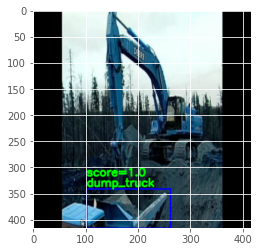

Image 1 done...
--------------------------------------------------


Image 2 done...
--------------------------------------------------


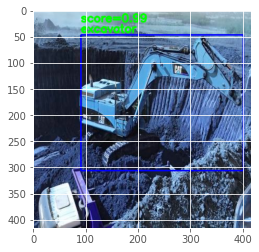

Image 3 done...
--------------------------------------------------


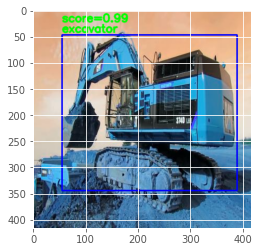

Image 4 done...
--------------------------------------------------


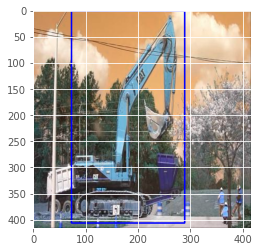

Image 5 done...
--------------------------------------------------


Image 6 done...
--------------------------------------------------


Image 7 done...
--------------------------------------------------


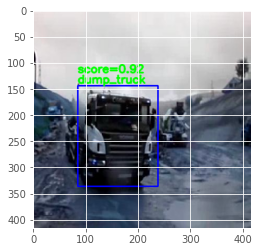

Image 8 done...
--------------------------------------------------


Image 9 done...
--------------------------------------------------


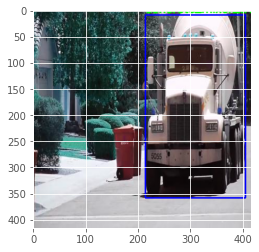

Image 10 done...
--------------------------------------------------


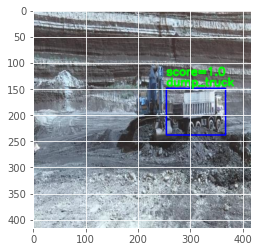

Image 11 done...
--------------------------------------------------


Image 12 done...
--------------------------------------------------


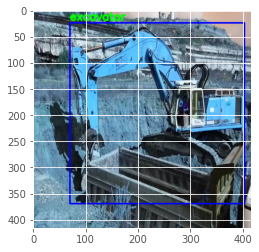

Image 13 done...
--------------------------------------------------


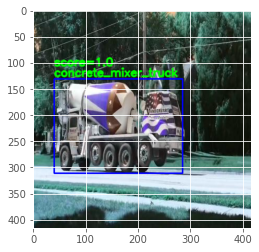

Image 14 done...
--------------------------------------------------


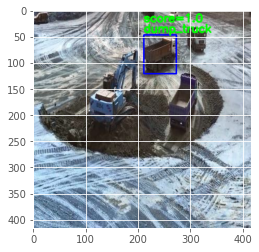

Image 15 done...
--------------------------------------------------


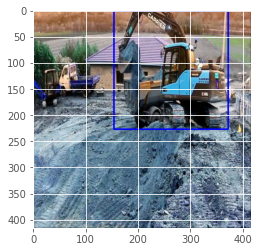

Image 16 done...
--------------------------------------------------


Image 17 done...
--------------------------------------------------


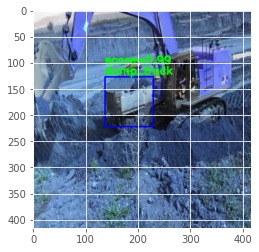

Image 18 done...
--------------------------------------------------


Image 19 done...
--------------------------------------------------


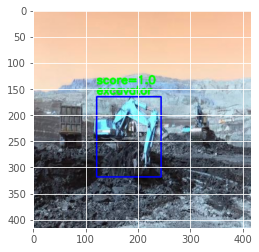

Image 20 done...
--------------------------------------------------


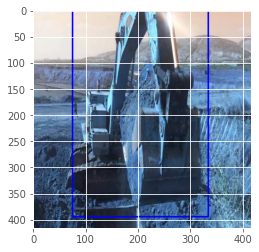

Image 21 done...
--------------------------------------------------


Image 22 done...
--------------------------------------------------


Image 23 done...
--------------------------------------------------


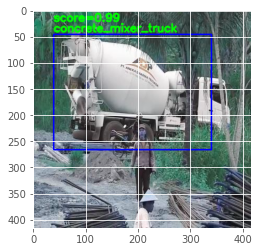

Image 24 done...
--------------------------------------------------


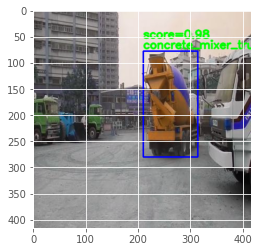

Image 25 done...
--------------------------------------------------


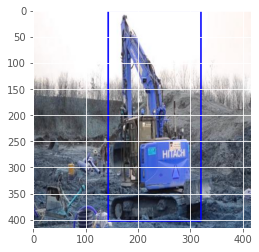

Image 26 done...
--------------------------------------------------


Image 27 done...
--------------------------------------------------


Image 28 done...
--------------------------------------------------


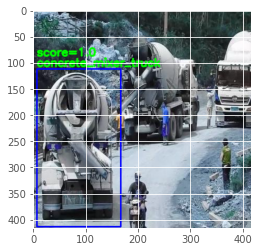

Image 29 done...
--------------------------------------------------


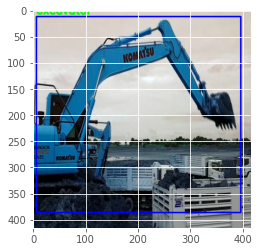

Image 30 done...
--------------------------------------------------


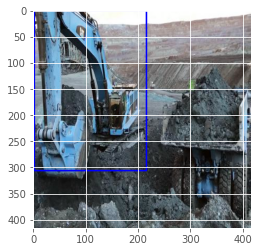

Image 31 done...
--------------------------------------------------


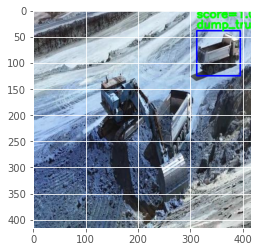

Image 32 done...
--------------------------------------------------


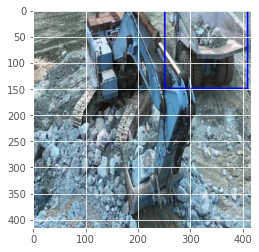

Image 33 done...
--------------------------------------------------


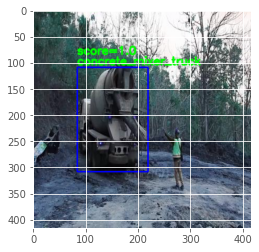

Image 34 done...
--------------------------------------------------


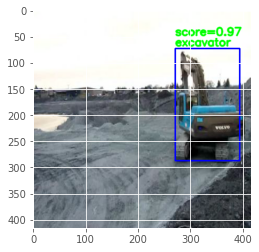

Image 35 done...
--------------------------------------------------


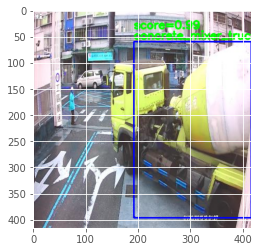

Image 36 done...
--------------------------------------------------


Image 37 done...
--------------------------------------------------


Image 38 done...
--------------------------------------------------


Image 39 done...
--------------------------------------------------


Image 40 done...
--------------------------------------------------


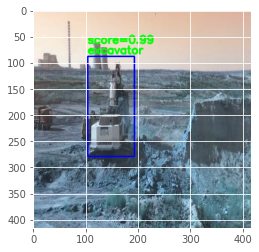

Image 41 done...
--------------------------------------------------


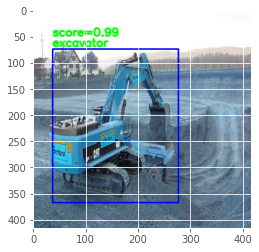

Image 42 done...
--------------------------------------------------


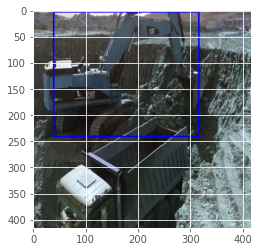

Image 43 done...
--------------------------------------------------


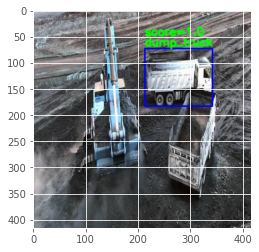

Image 44 done...
--------------------------------------------------


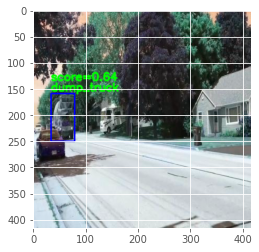

Image 45 done...
--------------------------------------------------


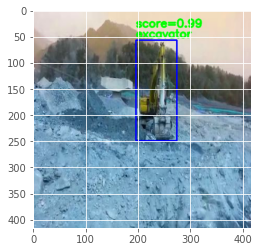

Image 46 done...
--------------------------------------------------


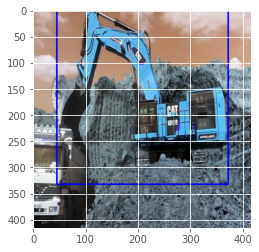

Image 47 done...
--------------------------------------------------


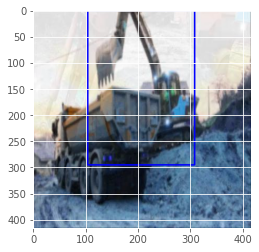

Image 48 done...
--------------------------------------------------


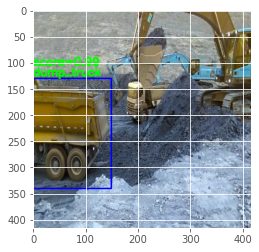

Image 49 done...
--------------------------------------------------


Image 50 done...
--------------------------------------------------
TEST PREDICTIONS COMPLETE
Testing Score :  0.96168256


In [9]:
####### inference.py #########
import numpy as np
import cv2
import torch
import glob as glob
# from model import create_model
# set the computation device
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
# load the model and the trained weights
model = create_model(num_classes=NUM_CLASSES).to(device)
model.load_state_dict(torch.load(
    '/content/gdrive/MyDrive/Colab Notebooks/output_rcnn/model'+ str(NUM_EPOCHS) +'.pth', map_location=device
))
model.eval()

# directory where all the images are present
TEST_NUMBER = 50
DIR_TEST = '/content/gdrive/MyDrive/Colab Notebooks/ACID.v1-acid01.voc/test'
test_images = glob.glob(f"{DIR_TEST}/*")
test_images = test_images[0:TEST_NUMBER];
print(f"Test instances: {len(test_images)}")
max_score_array = []
# define the detection threshold...
# ... any detection having score below this will be discarded
# detection_threshold = 0.12


for i in range(len(test_images)):
    # get the image file name for saving output later on
    image_name = test_images[i].split('/')[-1].split('.')[0]
    image = cv2.imread(test_images[i])
    orig_image = image.copy()
    # BGR to RGB
    image = cv2.cvtColor(orig_image, cv2.COLOR_BGR2RGB).astype(np.float32)
    # make the pixel range between 0 and 1
    image /= 255.0
    # bring color channels to front
    image = np.transpose(image, (2, 0, 1)).astype(np.float)
    # convert to tensor
    image = torch.tensor(image, dtype=torch.float).cuda()
    # add batch dimension
    image = torch.unsqueeze(image, 0)
    with torch.no_grad():
        outputs = model(image)
    
    # load all detection to CPU for further operations
    outputs = [{k: v.to('cpu') for k, v in t.items()} for t in outputs]
    # carry further only if there are detected boxes
    if len(outputs[0]['boxes']) != 0:
        boxes = outputs[0]['boxes'].data.numpy()
        scores = outputs[0]['scores'].data.numpy()
        # filter out boxes according to `detection_threshold`
        # boxes = boxes[scores >= detection_threshold].astype(np.int32)
        max_score = np.max(scores)
        max_score_array.append(max_score)
        boxes = boxes[scores >= max_score].astype(np.int32)

        draw_boxes = boxes.copy()
        # get all the predicited class names
        pred_classes = [CLASSES[i] for i in outputs[0]['labels'].cpu().numpy()]
        
        # draw the bounding boxes and write the class name on top of it
        for j, box in enumerate(draw_boxes):
            
            cv2.rectangle(orig_image,
                        (int(box[0]), int(box[1])),
                        (int(box[2]), int(box[3])),
                        (0, 0, 255), 2)
            cv2.putText(orig_image, pred_classes[j], 
                        (int(box[0]), int(box[1]-5)),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 
                        2, lineType=cv2.LINE_AA)
            cv2.putText(orig_image, "score="+str(np.round(max_score,2)), 
                        (int(box[0]), int(box[1]-25)),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 
                        2, lineType=cv2.LINE_AA)
        plt.imshow(orig_image)
        plt.savefig(f"/content/gdrive/MyDrive/Colab Notebooks/output_rcnn/test_predictions/{image_name}")
        plt.show()
        # cv2.imshow('Prediction', orig_image)
        # cv2.waitKey(1)
        
    print(f"Image {i+1} done...")
    print('-'*50)
print('TEST PREDICTIONS COMPLETE')
print('Testing Score : ', np.average(max_score_array))
# cv2.destroyAllWindows()